In [ ]:
# Description: This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM)
#              to predict the closing stock price of a corporation (Apple Inc.) using the past 60 days stock price.

In [ ]:
# Install the libraries
!pip install numpy
!pip install pandas
!pip install pandas-datareader
!pip install yfinance
!pip install scikit-learn
!pip install keras
!pip install tensorflow
!pip install matplotlib
!pip install datetime

In [ ]:
# Import the libraries
import tensorflow.compat.v1 as tf                # A library which is used for machine learning models
tf.disable_v2_behavior()                         # Disables TensorFlow version 2 behavior and enables version 1
tf.compat.v1.disable_eager_execution()           # Disables the TensorFlow eager execution mode
import pandas as pd                              # A library for data manipulation
import numpy as np                               # A library for numerical computing in Python
from pandas_datareader import data as pdr        # Alias for the pandas_datareader.data module
import yfinance as yfin                          # A library for downloading financial data from Yahoo Finance
from sklearn.preprocessing import MinMaxScaler   # A library for scaling numerical data
from keras.models import Sequential              # A library for building neural network models
from keras.layers import Dense, LSTM, Dropout    # Classes for defining layers in a neural network
import matplotlib.pyplot as plt                  # A library for creating data visualizations in Python

In [3]:
# Get the data using the yfinance library and the pandas-datareader API
import datetime 
yfin.pdr_override()
df = pdr.get_data_yahoo('AAPL', start='2020-01-01', end=datetime.date.today())

# Show the data
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.449394,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.735321,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.314880,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.970093,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.143898,132079200
...,...,...,...,...,...,...
2023-03-27,159.940002,160.770004,157.869995,158.279999,158.279999,52390300
2023-03-28,157.970001,158.490005,155.979996,157.649994,157.649994,45992200
2023-03-29,159.369995,161.050003,159.350006,160.770004,160.770004,51305700


<function matplotlib.pyplot.show(close=None, block=None)>

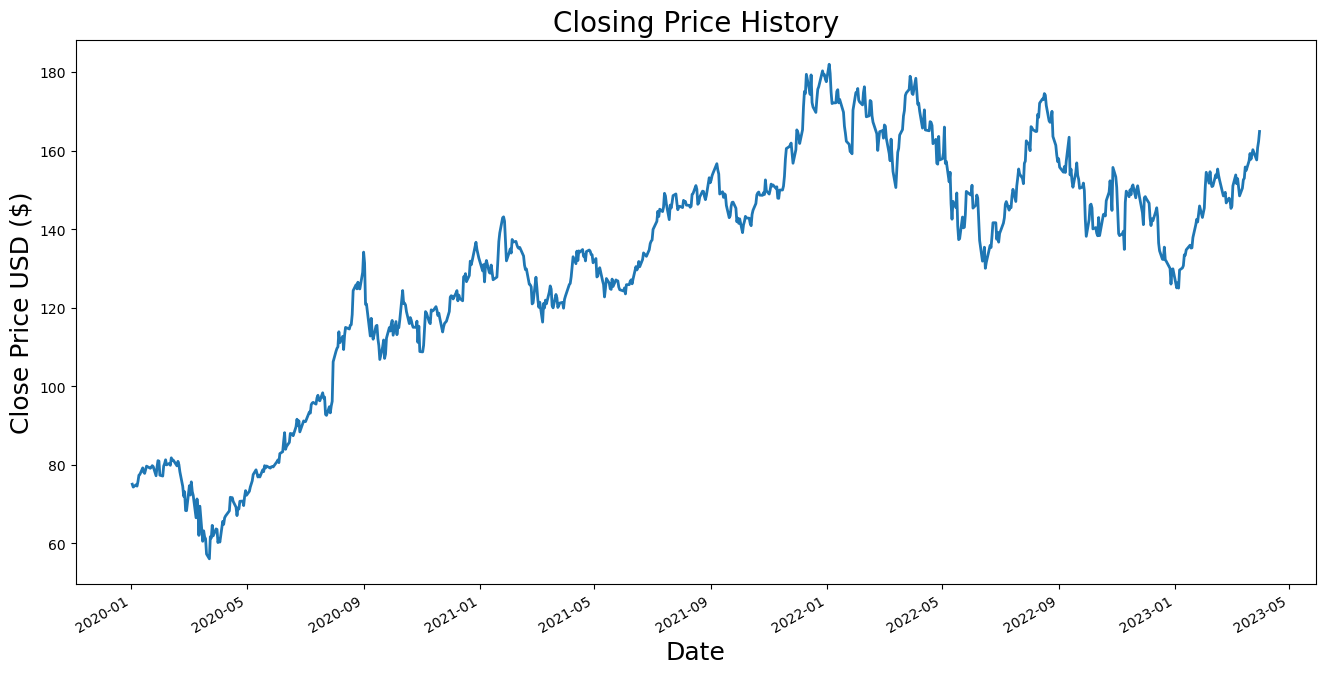

In [4]:
# Plot the closing price history

df['Close'].plot(figsize=(16,8), linewidth=2)
plt.title('Closing Price History', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show

In [ ]:
# Select only the 'Close' column from the dataframe and convert it to a numpy array
dataset = df[['Close']].values

# Determine the number of rows to be used for training
training_data_len = int(len(dataset) * 0.8)

print(training_data_len)

In [ ]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))  # Scale the data between 0 and 1
scaled_data = scaler.fit_transform(dataset) # Apply the scaler to the dataset

In [ ]:
# Create the training dataset

# Create a new array containing scaled values
train_data=scaled_data[0:training_data_len, :]

# Split the data into x_train and y_train datasets
x_train = [] # Will contain the past 60 days' data for training
y_train = [] # Will contain the actual stock prices for the training data

# Loop through the training data, creating x_train and y_train datasets
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])  # Append the past 60 values to the x_train list
    y_train.append(train_data[i, 0])       # Append the actual stock price for the next day to the y_train list
    
# Convert the x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the data to 3 dimensions because the LSTM model expects a 3D input shape
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
# Build the LSTM model

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile the model with an optimizer and a loss function
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, epochs=100, batch_size=32)

In [ ]:
# Create the testing dataset

# Create a new array containing scaled values
test_data = scaled_data[training_data_len - 60:, :]

# Create the datasets x_test and y_test
x_test = np.array([test_data[i-60:i, 0] for i in range(60, len(test_data))]) # Will contain the input features for the model
y_test = dataset[training_data_len:, :] # Will contain the actual stock prices for the testing data

# Convert the data to a numpy array to use it in the LSTM model
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# Predict the stock prices using the trained LSTM model on the testing data
predictions = scaler.inverse_transform(model.predict(x_test)) # Inverse transform the predictions to the original scale

In [ ]:
# Visualize the predicted values alongside the actual values

# Get the training and validation datasets
train = df[['Close']].iloc[:training_data_len]
valid = df[['Close']].iloc[training_data_len:]

# Add the predicted Close prices as a new column named 'Predictions'
valid['Predictions'] = predictions

# Print the validation dataset with the actual and predicted Close prices
print(valid)

# Show the average error between the actual values and the predictions
avg_error = round(np.mean(np.abs(valid.iloc[:,0] - valid.iloc[:,1])), 2)
print(f"\nAverage error: {avg_error}%")

In [12]:
# Predict the stock prices for the next days

# Define the number of days to predict
num_days = 10

# Select the last 60 closing prices from the 'Close' column and reshape the array to have a single feature
last_60_days = df['Close'][-60:].values.reshape(-1,1)

# Create an empty array to store the predicted prices
predicted_prices = []

# Loop through the number of days and predict the price for each day
for i in range(num_days):
    last_60_days_scaled = scaler.transform(last_60_days) # Scale the data using the same scaler used on the training and testing data
    predicted_price_scaled_tomorrow = model.predict(np.array([last_60_days_scaled])) # Predict the scaled price for the next day using the LSTM model
    predicted_price_tomorrow = scaler.inverse_transform(predicted_price_scaled_tomorrow) # Reverse the scaling to get the predicted price in dollars
    predicted_prices.append(predicted_price_tomorrow[0][0]) # Add the predicted price to the list of predicted prices
    last_60_days = np.vstack((last_60_days[1:], predicted_price_tomorrow)) # Update the input array with the new predicted price

# Create an empty list to store the predicted prices and dates
predicted_data = []

# Loop through the number of days and add the predicted price and date to the list
for i in range(num_days):
    day = datetime.date.today() + datetime.timedelta(days=i+1)
    predicted_data.append({'Date': day, 'Predicted Price': predicted_prices[i]})

# Create a data frame from the list of dictionaries
df_predicted = pd.DataFrame(predicted_data)

# Set the Date column as the index
df_predicted.set_index('Date', inplace=True)

# Print the data frame
print(df_predicted)

            Predicted Price
Date                       
2023-04-04       158.462723
2023-04-05       158.977341
2023-04-06       159.133530
2023-04-07       158.931290
2023-04-08       158.493088
2023-04-09       157.949921
2023-04-10       157.391312
2023-04-11       156.861069
2023-04-12       156.372360
2023-04-13       155.923828


<function matplotlib.pyplot.show(close=None, block=None)>

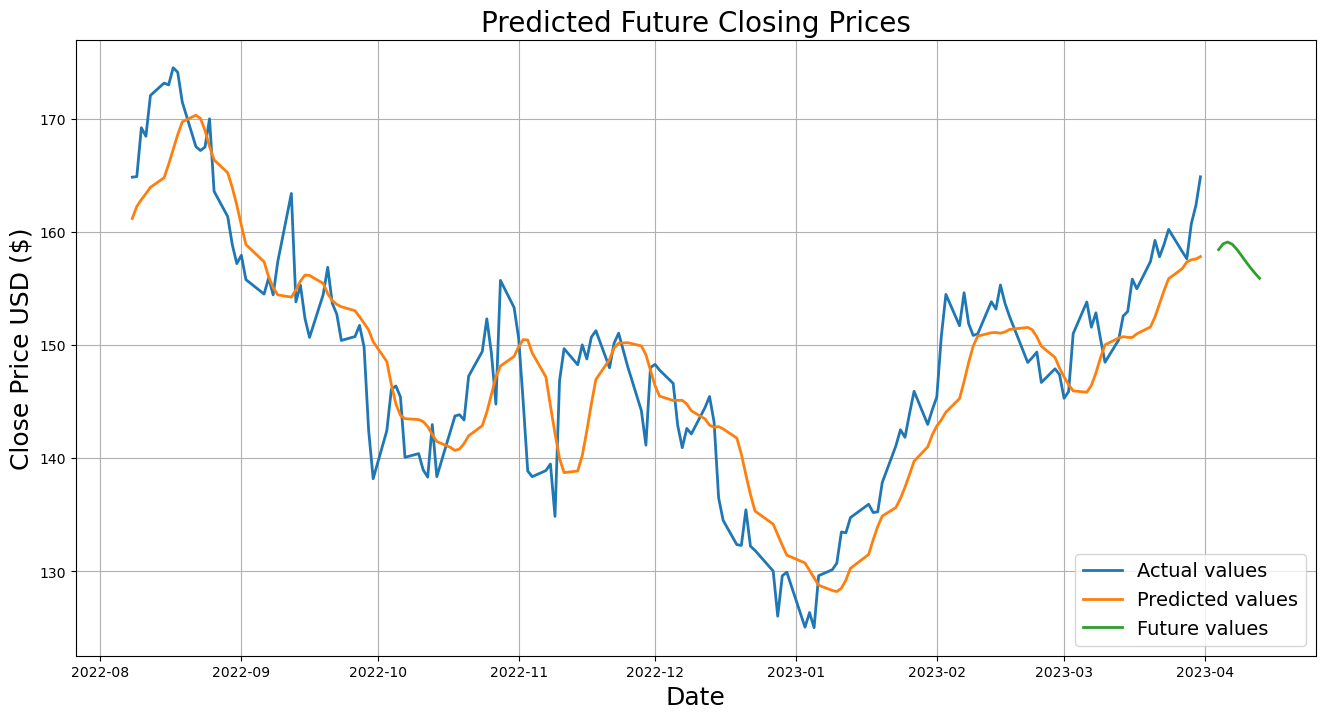

In [13]:
# Plot the predicted future closing prices

plt.figure(figsize=(16,8))
plt.plot(valid['Close'], linewidth=2)
plt.plot(valid['Predictions'], linewidth=2)
plt.plot(df_predicted['Predicted Price'], linewidth=2)
plt.title('Predicted Future Closing Prices', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(['Actual values', 'Predicted values', 'Future values'], fontsize=14, loc='lower right')
plt.grid(True)
plt.show